# Bank Note Dataset

# 1: Introduction

About this data
<br> The Banknote Dataset involves predicting whether a given banknote is authentic given a number of measures taken from a photograph.

It is a binary (2-class) classification problem. The number of observations for each class is not balanced. There are 1,372 observations with 4 input variables and 1 output variable. The variable names are as follows:

<br> 1. Variance of Wavelet Transformed image (continuous).
<br> 2. Skewness of Wavelet Transformed image (continuous).
<br> 3. Kurtosis of Wavelet Transformed image (continuous).
<br> 4. Entropy of image (continuous).
<br> 5. Class (0 for authentic, 1 for inauthentic).

# 2: Data Pre processing

## 2.1 Loading the required Libraries

In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## 2.2 Get Data

In [2]:
## Loading the dataset from github repo
url = 'https://raw.githubusercontent.com/hargurjeet/MachineLearning/Bank-Note-Dataset/BankNote_Authentication.csv'
df = pd.read_csv(url)

df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [4]:
df.shape

(1372, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


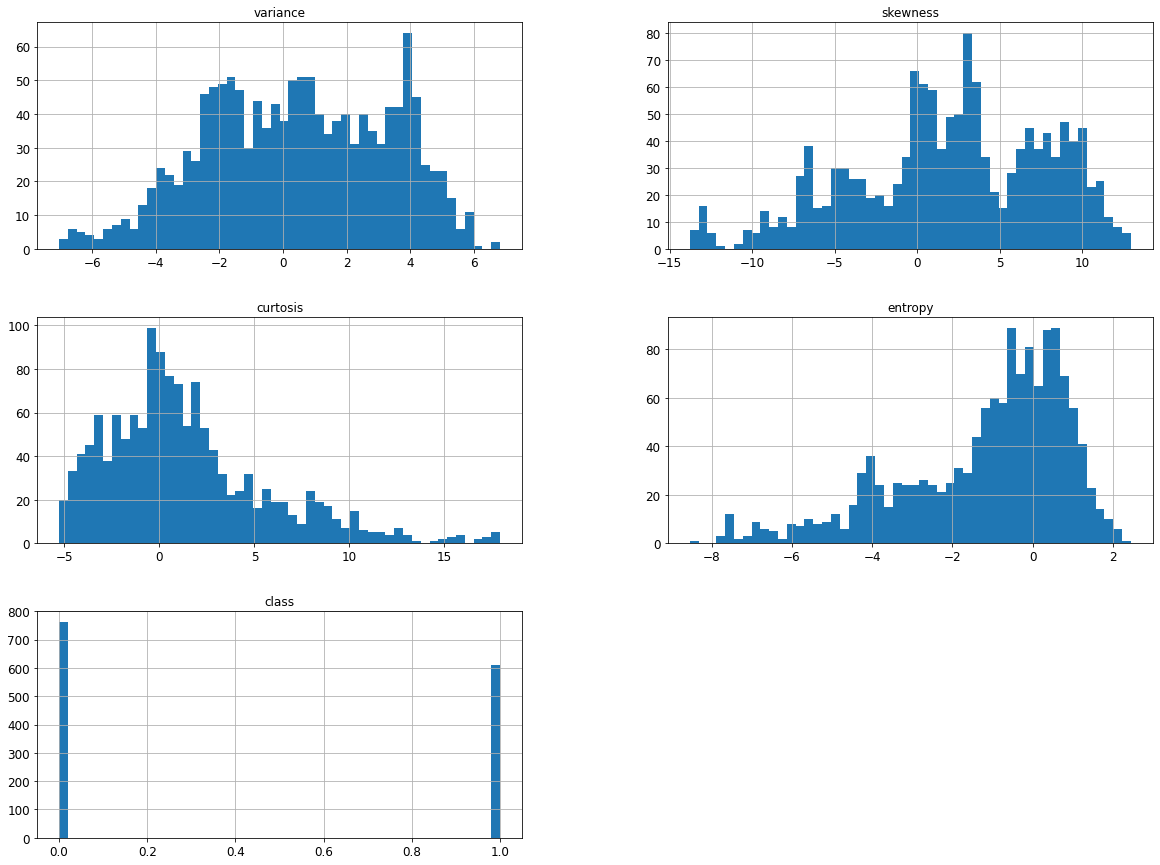

In [6]:
df.hist(bins=50, figsize=(20,15))
plt.show()

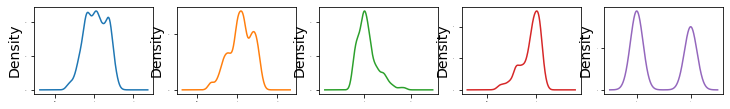

In [7]:
# density
df.plot(kind='density', subplots=True, layout=(8,8), sharex=False, legend=False, fontsize=1, figsize=(20,15))
plt.show()

## 2.3 Cleaning the dataset

In [8]:
df.duplicated().sum()

24

In [9]:
# Dropping all the duplicate values
df.drop_duplicates(subset=None, keep='first', inplace=True)

In [10]:
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
variance,1348.0,0.445785,2.862906,-7.0421,-1.78665,0.518735,2.853250,6.8248
skewness,1348.0,1.909039,5.868600,-13.7731,-1.62700,2.334150,6.796025,12.9516
curtosis,1348.0,1.413578,4.328365,-5.2861,-1.54560,0.605495,3.199800,17.9274
entropy,1348.0,-1.168712,2.085877,-8.5482,-2.39310,-0.578890,0.403863,2.4495
class,1348.0,0.452522,0.497925,0.0000,0.00000,0.000000,1.000000,1.0000


## 2.4 Feature Analysis

In [12]:
# Detecting the outliers
def detect_outlier(data):
    outlier = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i - mean)/std
        if np.abs(z_score)>threshold:
            outlier.append(i)
    return outlier

In [13]:
var_list = df['variance'].tolist()
skew_list = df['skewness'].tolist()
curt_list = df['curtosis'].tolist()
entr_list = df['entropy'].tolist()

In [14]:
var_outlier = detect_outlier(var_list)
print(var_outlier)

skew_list = detect_outlier(skew_list)
print(skew_list)

curt_list = detect_outlier(curt_list)
print(curt_list)

entr_list = detect_outlier(entr_list)
print(entr_list)

[]
[]
[15.6824, 17.6772, 14.9704, 17.3087, 15.5573, 17.9274, 16.9583, 14.8881, 17.5795, 15.6773, 17.6052, 15.6199, 17.1116, 15.6559, 17.0834, 15.4417, 16.7166, 15.1606, 17.5932]
[-7.5034, -7.5836, -7.5034, -7.7853, -7.7581, -8.5482, -7.5487, -7.6418, -7.8719, -7.6612, -7.5034, -7.5344, -7.5887, -7.5642, -7.5887]


In [15]:
print('Total Records before dropping:', df.shape)

Total Records before dropping: (1348, 5)


In [16]:
df.drop(df[df['curtosis'] >= 14.9704].index, inplace = True) 
df.drop(df[df['entropy'] <= -7.5034].index, inplace = True)

In [17]:
# Final reshaped dataset
df.shape

(1315, 5)

# 3: Preparing the data for ML

## 3.1 Applying Train,test and Split

In [18]:
## Splittng the dataset to train,test and split
from sklearn.model_selection import train_test_split

X = df.iloc[:,0:-1]
Y = df.iloc[:,-1]
validation_size = 0.2
seed = 7
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed,shuffle=True)

# 4: Building ML models

## 4.1 Analysing the best model

In [19]:
# test options
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check some algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [20]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, X_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.993351 (0.007409)
LDA: 0.987655 (0.009547)
KNN: 0.998104 (0.003792)
CART: 0.985741 (0.010612)
NB: 0.858347 (0.025281)
SVM: 0.996199 (0.004655)


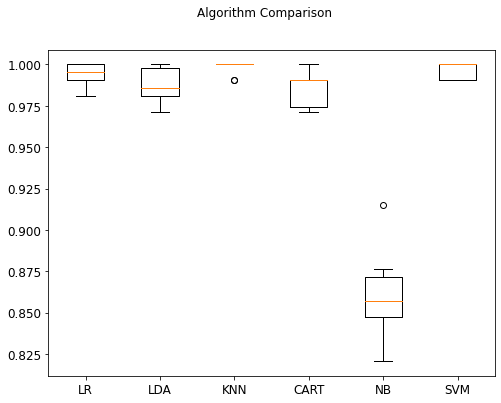

In [21]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,6)
plt.show()

## 4.2 Building Pipelines on Standardized Dataset

In [22]:
# standardized the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, X_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.991456 (0.006637)
ScaledLDA: 0.987655 (0.009547)
ScaledKNN: 0.998095 (0.003810)
ScaledCART: 0.986685 (0.009702)
ScaledNB: 0.858347 (0.025281)
ScaledSVM: 0.998095 (0.003810)


Best Accuracy is with the following models
<br> KNeighborsClassifier
<br> SVM

## 4.3 Hyperparameter Tunning

In [24]:
# KNN algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle =True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, X_test)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.998095 using {'n_neighbors': 1}
#1 0.998095 (0.003810) with: {'n_neighbors': 1}
#1 0.998095 (0.003810) with: {'n_neighbors': 3}
#1 0.998095 (0.003810) with: {'n_neighbors': 5}
#4 0.995247 (0.004753) with: {'n_neighbors': 7}
#11 0.992390 (0.005711) with: {'n_neighbors': 9}
#7 0.993342 (0.004359) with: {'n_neighbors': 11}
#7 0.993342 (0.004359) with: {'n_neighbors': 13}
#5 0.994295 (0.004658) with: {'n_neighbors': 15}
#5 0.994295 (0.004658) with: {'n_neighbors': 17}
#7 0.993342 (0.006094) with: {'n_neighbors': 19}
#7 0.993342 (0.006094) with: {'n_neighbors': 21}


In [25]:
# SVM algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, X_test)

In [26]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 1.000000 using {'C': 1.5, 'kernel': 'rbf'}
#27 0.990503 (0.009506) with: {'C': 0.1, 'kernel': 'linear'}
#30 0.968598 (0.015970) with: {'C': 0.1, 'kernel': 'poly'}
#9 0.995247 (0.004753) with: {'C': 0.1, 'kernel': 'rbf'}
#31 0.880261 (0.033181) with: {'C': 0.1, 'kernel': 'sigmoid'}
#11 0.992408 (0.007096) with: {'C': 0.3, 'kernel': 'linear'}
#28 0.990494 (0.008498) with: {'C': 0.3, 'kernel': 'poly'}
#9 0.995247 (0.004753) with: {'C': 0.3, 'kernel': 'rbf'}
#32 0.845076 (0.032052) with: {'C': 0.3, 'kernel': 'sigmoid'}
#11 0.992408 (0.007096) with: {'C': 0.5, 'kernel': 'linear'}
#21 0.991447 (0.008964) with: {'C': 0.5, 'kernel': 'poly'}
#8 0.997152 (0.004351) with: {'C': 0.5, 'kernel': 'rbf'}
#33 0.826056 (0.032085) with: {'C': 0.5, 'kernel': 'sigmoid'}
#11 0.992408 (0.007096) with: {'C': 0.7, 'kernel': 'linear'}
#28 0.990494 (0.009506) with: {'C': 0.7, 'kernel': 'poly'}
#5 0.998095 (0.003810) with: {'C': 0.7, 'kernel': 'rbf'}
#34 0.816541 (0.030105) with: {'C': 0.7, 'kernel': 'sigmo

## 4.4 Running the ML on best optimal parameters identified

In [27]:
## Preparing Model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(C=1.5) # rbf is default kernel
model.fit(rescaledX, X_test)

SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
# estimate accuracy on validation set
rescaledValidationX = scaler.transform(Y_train)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

1.0
[[152   0]
 [  0 111]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00       111

    accuracy                           1.00       263
   macro avg       1.00      1.00      1.00       263
weighted avg       1.00      1.00      1.00       263



The accuracy on the validation set was 100%.

In [30]:
some_date = X_train.iloc[0 : 6]
some_labels = X_test.iloc[0:6]

some_date_prepared = scaler.transform(some_date)

print("Predictions:", model.predict(some_date_prepared))
print("Labels:", list(some_labels))

Predictions: [0 1 0 0 1 0]
Labels: [0, 1, 0, 0, 1, 0]
